<a href="https://colab.research.google.com/github/nandhureji1731/springboardmentor5959e/blob/main/oil_spill__detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

WEEK 1-2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Path where dataset is stored inside Drive
BASE_PATH = "/content/drive/MyDrive/dataset/"
TRAIN_IMG_DIR = BASE_PATH + "train/images/"
TRAIN_MASK_DIR = BASE_PATH + "train/masks/"

Mounted at /content/drive


In [3]:

import tensorflow as tf
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
from sklearn.model_selection import train_test_split

In [4]:
def load_data(img_dir, mask_dir, img_size=(256, 256)):
    images, masks = [], []


    if not os.path.exists(img_dir):
        print(f"Error: Image directory not found: {img_dir}")
        return None, None
    if not os.path.exists(mask_dir):
        print(f"Error: Mask directory not found: {mask_dir}")
        return None, None

    print(f"Contents of image directory {img_dir}: {os.listdir(img_dir)[:10]}...") # Print first 10 files
    print(f"Contents of mask directory {mask_dir}: {os.listdir(mask_dir)[:10]}...") # Print first 10 files


    img_files = sorted(os.listdir(img_dir))
    mask_files = sorted(os.listdir(mask_dir))

    if len(img_files) != len(mask_files):
        print(f"Warning: Number of image files ({len(img_files)}) does not match number of mask files ({len(mask_files)}).")


    for img_name, mask_name in zip(img_files, mask_files):
        img_path = os.path.join(img_dir, img_name)
        mask_path = os.path.join(mask_dir, mask_name)


        img = cv2.imread(img_path)
        if img is None:
            print(f"Warning: Could not load image file: {img_path}. Skipping.")
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, img_size)
        img = img / 255.0

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            print(f"Warning: Could not load mask file: {mask_path}. Skipping.")
            continue
        mask = cv2.resize(mask, img_size)
        mask = mask / 255.0

        images.append(img)
        masks.append(mask.reshape(img_size[0], img_size[1], 1))

    return np.array(images), np.array(masks)

X, Y = load_data(TRAIN_IMG_DIR, TRAIN_MASK_DIR)

if X is not None and Y is not None:
    print("Images shape:", X.shape)
    print("Masks shape:", Y.shape)

Contents of image directory /content/drive/MyDrive/dataset/train/images/: ['Oil (225).jpg', 'Oil (652).jpg', 'Oil (72).jpg', 'Oil (1157).jpg', 'Oil (122).jpg', 'Oil (107).jpg', 'Oil (450).jpg', 'Oil (1054).jpg', 'Oil (297).jpg', 'Oil (523).jpg']...
Contents of mask directory /content/drive/MyDrive/dataset/train/masks/: ['Oil (503).png', 'Oil (676).png', 'Oil (551).png', 'Oil (652).png', 'Oil (989).png', 'Oil (481).png', 'Oil (163).png', 'Oil (73).png', 'Oil (1054).png', 'Oil (830).png']...
Images shape: (811, 256, 256, 3)
Masks shape: (811, 256, 256, 1)


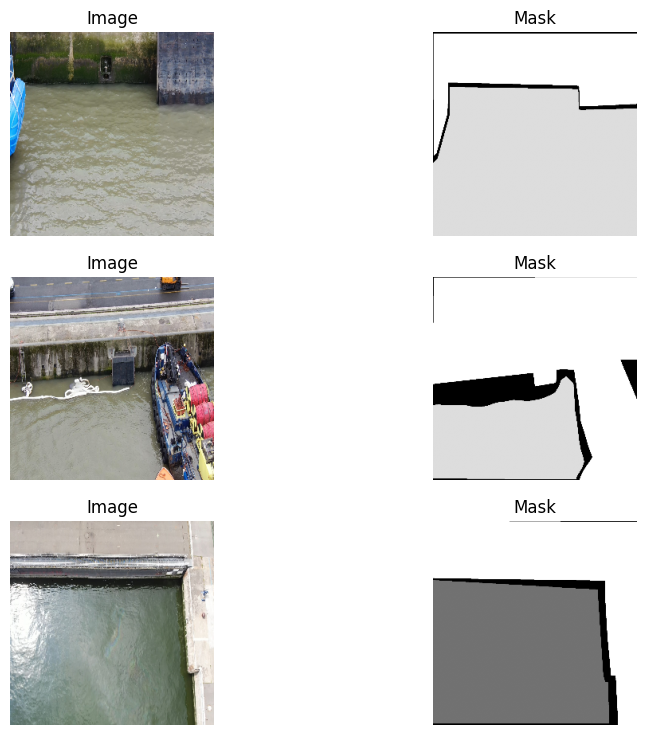

In [5]:
def visualize_samples(X, Y, num_samples=3):
    if X is None or Y is None:
        print("Cannot visualize samples: Data not loaded properly.")
        return

    plt.figure(figsize=(10, num_samples * 3))
    for i in range(num_samples):
        idx = np.random.randint(0, len(X))
        plt.subplot(num_samples, 2, 2*i+1)
        plt.imshow(X[idx])
        plt.title("Image")
        plt.axis("off")

        plt.subplot(num_samples, 2, 2*i+2)
        plt.imshow(Y[idx].squeeze(), cmap="gray")
        plt.title("Mask")
        plt.axis("off")
    plt.show()

visualize_samples(X, Y)

In [6]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

print("Training set:", X_train.shape, Y_train.shape)
print("Validation set:", X_val.shape, Y_val.shape)


Training set: (648, 256, 256, 3) (648, 256, 256, 1)
Validation set: (163, 256, 256, 3) (163, 256, 256, 1)


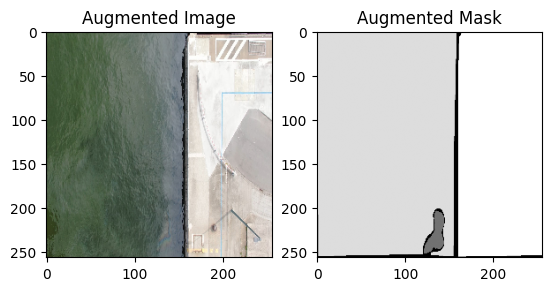

In [7]:
augment = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.2)
])

def augment_data(image, mask):
    augmented = augment(image=(image*255).astype(np.uint8), mask=(mask*255).astype(np.uint8))
    return augmented['image']/255.0, augmented['mask']/255.0

#Eg
aug_img, aug_mask = augment_data(X[0], Y[0])

plt.subplot(1,2,1)
plt.imshow(aug_img)
plt.title("Augmented Image")

plt.subplot(1,2,2)
plt.imshow(aug_mask, cmap="gray")
plt.title("Augmented Mask")
plt.show()


WEEK 3-4

import


In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np


 model

In [9]:

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def conv_block(x, filters):
    x = layers.Conv2D(filters, (3,3), padding="same", activation="relu")(x)
    x = layers.Conv2D(filters, (3,3), padding="same", activation="relu")(x)
    return x

def encoder_block(x, filters):
    c = conv_block(x, filters)
    p = layers.MaxPooling2D((2,2))(c)
    return c, p

def decoder_block(x, skip, filters):
    us = layers.Conv2DTranspose(filters, (2,2), strides=(2,2), padding="same")(x)
    concat = layers.Concatenate()([us, skip])
    c = conv_block(concat, filters)
    return c

def build_unet(input_shape=(128,128,3)):
    inputs = layers.Input(input_shape)

    # Encoder
    c1, p1 = encoder_block(inputs, 32)
    c2, p2 = encoder_block(p1, 64)
    c3, p3 = encoder_block(p2, 128)

    # Bottleneck
    bn = conv_block(p3, 256)

    # Decoder
    d1 = decoder_block(bn, c3, 128)
    d2 = decoder_block(d1, c2, 64)
    d3 = decoder_block(d2, c1, 32)

    outputs = layers.Conv2D(1, (1,1), activation="sigmoid")(d3)

    model = models.Model(inputs, outputs)
    return model

# Build model
model = build_unet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy", dice_coef])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │    131,200 │ conv2d_7[0][0]    │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 256)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │    295,040 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │    147,584 │ conv2d_8[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 64, 64,    │     32,832 │ conv2d_9[0][0]  

 Total params: 1,925,601 (7.35 MB)

 Trainable params: 1,925,601 (7.35 MB)

 Non-trainable params: 0 (0.00 B)

resize for faster execution

In [10]:
IMG_SIZE = (128,128)  # faster than 256x256

X_small, Y_small = load_data(TRAIN_IMG_DIR, TRAIN_MASK_DIR, img_size=IMG_SIZE)

X_train, X_val, Y_train, Y_val = train_test_split(X_small, Y_small, test_size=0.2, random_state=42)

print("Train:", X_train.shape, "Val:", X_val.shape)


Contents of image directory /content/drive/MyDrive/dataset/train/images/: ['Oil (225).jpg', 'Oil (652).jpg', 'Oil (72).jpg', 'Oil (1157).jpg', 'Oil (122).jpg', 'Oil (107).jpg', 'Oil (450).jpg', 'Oil (1054).jpg', 'Oil (297).jpg', 'Oil (523).jpg']...
Contents of mask directory /content/drive/MyDrive/dataset/train/masks/: ['Oil (503).png', 'Oil (676).png', 'Oil (551).png', 'Oil (652).png', 'Oil (989).png', 'Oil (481).png', 'Oil (163).png', 'Oil (73).png', 'Oil (1054).png', 'Oil (830).png']...
Train: (648, 128, 128, 3) Val: (163, 128, 128, 3)


metrics and compile model

In [11]:
def iou_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=[ "accuracy",dice_coef])


Train

In [12]:
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    batch_size=8,
    epochs=20,
    verbose=1
)


Epoch 1/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 23s 85ms/step - accuracy: 0.0055 - dice_coef: 0.5856 - loss: 0.6741 - val_accuracy: 0.0178 - val_dice_coef: 0.6081 - val_loss: 0.6455
Epoch 2/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.0133 - dice_coef: 0.6229 - loss: 0.6414 - val_accuracy: 0.0270 - val_dice_coef: 0.6079 - val_loss: 0.6363
Epoch 3/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.0188 - dice_coef: 0.6213 - loss: 0.6333 - val_accuracy: 0.0292 - val_dice_coef: 0.5971 - val_loss: 0.6417
Epoch 4/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.0185 - dice_coef: 0.6184 - loss: 0.6372 - val_accuracy: 0.0365 - val_dice_coef: 0.6231 - val_loss: 0.6249
Epoch 5/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.0214 - dice_coef: 0.6259 - loss: 0.6265 - val_accuracy: 0.0266 - val_dice_coef: 0.6488 - val_loss: 0.6334
Epoch 6/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.0229 - dice_coef: 0.6233 - loss: 0.6322 - val_accuracy: 0.0399 - val_dice_coef:

Visual

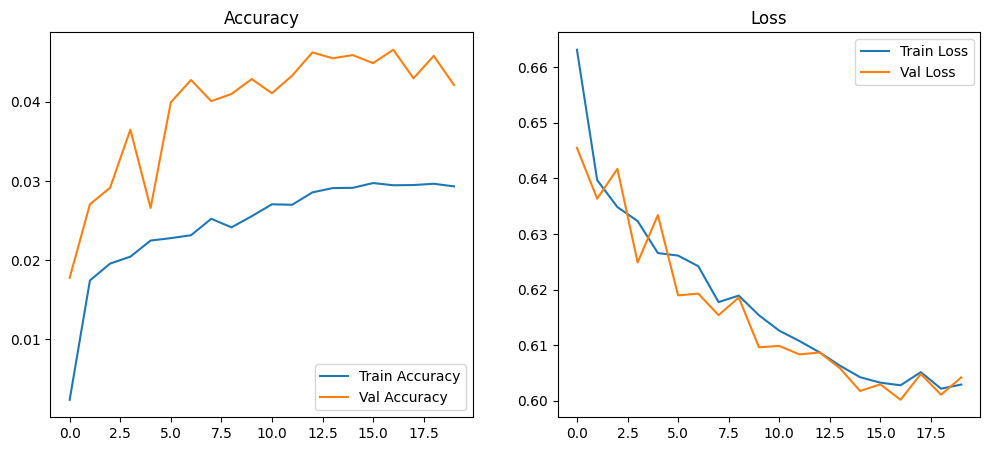

In [13]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
if 'accuracy' in history.history:
  plt.plot(history.history["accuracy"], label="Train Accuracy")
if 'val_accuracy' in history.history:
  plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 696ms/step


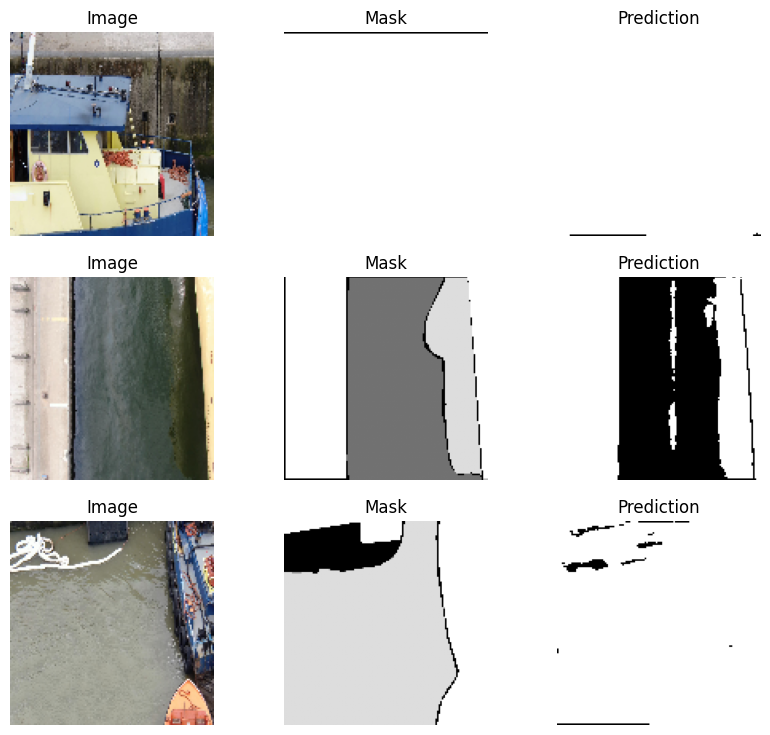

In [14]:
def show_predictions(model, X, Y, num=3):
    preds = model.predict(X[:num])
    plt.figure(figsize=(10, num*3))
    for i in range(num):
        plt.subplot(num,3,3*i+1)
        plt.imshow(X[i])
        plt.title("Image")
        plt.axis("off")

        plt.subplot(num,3,3*i+2)
        plt.imshow(Y[i].squeeze(), cmap="gray")
        plt.title("Mask")
        plt.axis("off")

        plt.subplot(num,3,3*i+3)
        plt.imshow((preds[i].squeeze() > 0.5), cmap="gray")
        plt.title("Prediction")
        plt.axis("off")
    plt.show()

show_predictions(model, X_val, Y_val, num=3)


week 5-6


In [15]:
import tensorflow.keras.backend as K

def iou_metric(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)

def precision_metric(y_true, y_pred):
    y_pred_f = K.round(K.flatten(y_pred))
    y_true_f = K.flatten(y_true)
    tp = K.sum(y_true_f * y_pred_f)
    fp = K.sum((1 - y_true_f) * y_pred_f)
    return tp / (tp + fp + K.epsilon())

def recall_metric(y_true, y_pred):
    y_pred_f = K.round(K.flatten(y_pred))
    y_true_f = K.flatten(y_true)
    tp = K.sum(y_true_f * y_pred_f)
    fn = K.sum(y_true_f * (1 - y_pred_f))
    return tp / (tp + fn + K.epsilon())

# Recompile model with full metrics
model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy", dice_coef, iou_metric, precision_metric, recall_metric])

evaluation on valid set

In [16]:
results = model.evaluate(X_val, Y_val, verbose=1)
print("Validation Results:")
for name, val in zip(model.metrics_names, results):
    print(f"{name}: {val:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 172ms/step - accuracy: 0.0544 - dice_coef: 0.6462 - iou_metric: 0.4774 - loss: 0.6038 - precision_metric: 0.7041 - recall_metric: 0.7955
Validation Results:
loss: 0.6042
compile_metrics: 0.0421


plot training curves

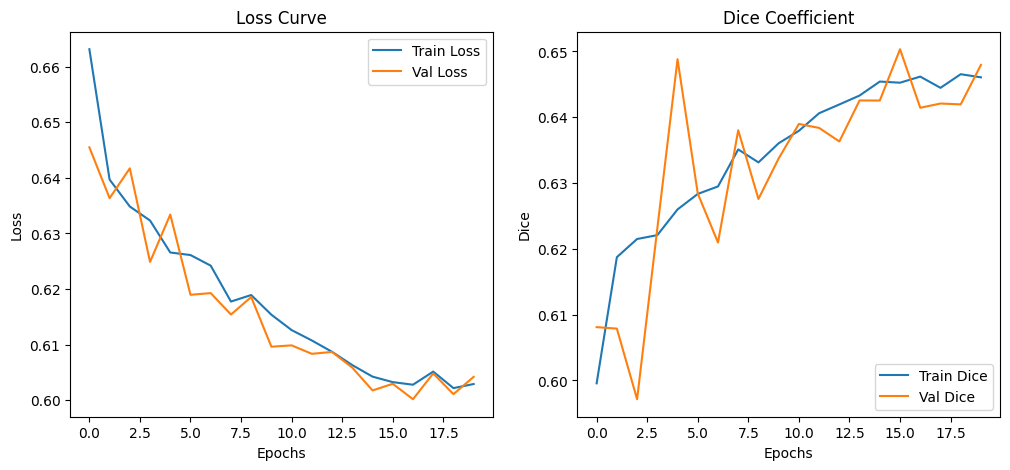

In [17]:
def plot_training(history):
    plt.figure(figsize=(12,5))

    # Loss
    plt.subplot(1,2,1)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.title("Loss Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Dice Coefficient
    plt.subplot(1,2,2)
    plt.plot(history.history["dice_coef"], label="Train Dice")
    plt.plot(history.history["val_dice_coef"], label="Val Dice")
    plt.title("Dice Coefficient")
    plt.xlabel("Epochs")
    plt.ylabel("Dice")
    plt.legend()

    plt.show()

plot_training(history)

side by side visualisation

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


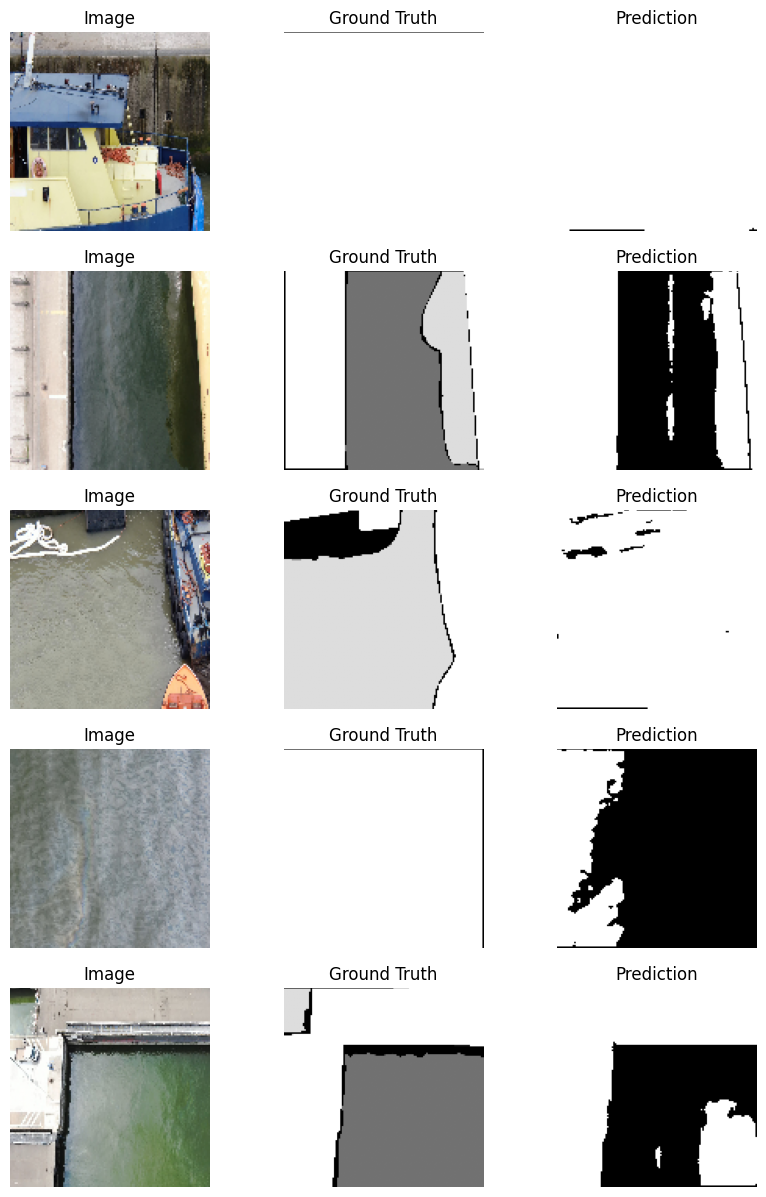

In [18]:
def compare_predictions(model, X, Y, num=3):
    preds = model.predict(X[:num])
    plt.figure(figsize=(10, num*3))
    for i in range(num):
        plt.subplot(num,3,3*i+1)
        plt.imshow(X[i])
        plt.title("Image")
        plt.axis("off")

        plt.subplot(num,3,3*i+2)
        plt.imshow(Y[i].squeeze(), cmap="gray")
        plt.title("Ground Truth")
        plt.axis("off")

        plt.subplot(num,3,3*i+3)
        plt.imshow((preds[i].squeeze() > 0.5), cmap="gray")
        plt.title("Prediction")
        plt.axis("off")
    plt.show()

compare_predictions(model, X_val, Y_val, num=5)